# An overview of quality assurance practices in computational research

Authors: James Davenport, Steven Lamerton, Oliver Laslett, Vincent Knight, James Hetherington

Abstract: Research software has fundamentally different life cycles from commercial software. While this is (implcitly) recognised by authors and funders, its implications for the testing regime have not been clearly articulated. Here the authors from several UK research institutions have pooled their views on the testing strategies appropriate to research software at various stages of its evolution. What is sufficient for a program being used by one reserach student to underpin a thesis is probably insufficient for a program being used by many people, most of whom never read the source, in many institutons, on a wide range of computers.

In [43]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation

### Floating Point and Testing

Nearly all computational research is done using the floating-point arithmetic supplied by the vendor. These days this is normally assumed to conform to the IEEE (binary) floating point system \cite{IEEE2008}, which specifies the results of a sequence of floating-point operations. This actually \emph{does} simplify the developers' life (compared to the days of negotiating hexadecimal-based IBM formats etc.), but does \emph{not} mean that there are no problems with the floating point. 


* Floating-pont may not produce the expected results:

  \begin{equation}
  \left(1+10^{20}\right)-10^{20}=10^{20}-10^{20}=0,
  \end{equation}

  not the $1$ one might expect. Of course,

  \begin{equation}
  1+\left(10^{20}-10^{20}\right)=1+0=1.
  \end{equation}

* \cite{IEEE2008} does specify the result of a sequence of floating-point operations, but the user may not! In particular, in most programming languages, 

  \begin{equation}
  1+10^{20}-10^{20}
  \end{equation}

  is ambiguous as to whether it is (1) or  (2), and therefore the compiler is free to produce 1 or 0. In practice, of course, the code will not be (3) but `!a+b+c!`, and indeed `!a!` etc. will probably be array elements, or expressions themselves. A slight change in \verb!a! etc., or indeed in the surrounding program, can change which order the compiler chooses to do the additions in, and, as we have seen, change the result.




### Property based testing

In \cite{Claessen2000} a novel testing approach was described: _property based
testing_. Claessen and Hughes describe a Haskell package **QuickCheck** that
allows for the testing of functions under random inputs. In this instance it is
often not the exact output that gets tested but the "property" of the output
(thus where the name of this paradigm originates). Since this initial work some
further property based testing has been provided. In \cite{Arts2008} a mechanism
of shrinking (implemented in **Quviq QuickCheck**) of failed test cases is
described: when a given set of inputs is found that fails a test it is shrunk to
it a simplest form that still fails the test. As failing parameters are of
course reported: this aids in debugging. Other similar yet adjacent testing
frameworks are described in \cite{Runciman2008, Yang2006}, these include testing
of storage as well as exhaustive parameter testing.

In Python an implementation of _property based testing_ is implemented in the
hypothesis library \cite{hypothesis3.1}. This implements shrinking as described
above. As an example let us consider the following function which implements the
following (erroneous) property of a number that is divisible or not by 11:

> A number is divisible by 11 if and only if the alternating (in sign) sum of
> the number’s digits is 0.

As an example consider $121$, the alternating sum is: $1-2+1=0$ and indeed
$121=11\times 11$.

In [44]:
def divisible_by_11(number):
    """Uses above criterion to check if number is divisible by 11"""
    string_number = str(number)
    alternating_sum = sum([(-1) ** i * int(d) for i, d
                           in enumerate(string_number)])
    return alternating_sum == 0

In [45]:
import unittest

class TestDivisible(unittest.TestCase):
    def test_divisible_by_11(self):

        for k in range(10):
            self.assertTrue(divisible_by_11(11 * k))
            self.assertFalse(divisible_by_11(11 * k + 1))

        # Some more examples
        self.assertTrue(divisible_by_11(121))
        self.assertTrue(divisible_by_11(12122))

        self.assertFalse(divisible_by_11(123))
        self.assertFalse(divisible_by_11(12123))

TestDivisible().test_divisible_by_11()

ValueError: no such test method in <class '__main__.TestDivisible'>: runTest

Running the above gives no failures. Below implements a basic hypothesis test:

In [ ]:
from hypothesis import given  # This is how we will define inputs
from hypothesis.strategies import integers  # This is the type of input we will use

class TestDivisible(unittest.TestCase):

    @given(k=integers(min_value=1))  # This is the main decorator
    def test_divisible_by_11(self, k):
        self.assertTrue(divisible_by_11(11 * k))

TestDivisible().test_divisible_by_11()

An error is returned and hypothesis identifies that $k=19$ gives a failure.
Indeed: $19\times 11= 209$. This indicates that our original property for
divisibility by 11 does not hold, some basic algebra would confirm this, giving:

> A number is divisible by 11 if and only if the alternating (in sign) sum of
> the number’s digits is divisible by 11.

This can be implemented in python using:

In [ ]:
def divisible_by_11(number):
    """Uses above criterion to check if number is divisible by 11"""
    string_number = str(number)
    # Using abs as the order of the alternating sum doesn't matter.
    alternating_sum = abs(sum([(-1) ** i * int(d) for i, d
                               in enumerate(string_number)]))
    # Recursively calling the function
    return (alternating_sum in [0, 11]) or divisible_by_11(alternating_sum)

Rerunning the tests gives no failures:

In [ ]:
class TestDivisible(unittest.TestCase):

    @given(k=integers(min_value=1))  # This is the main decorator
    def test_divisible_by_11(self, k):
        self.assertTrue(divisible_by_11(11 * k))

TestDivisible().test_divisible_by_11()

## Continuous Integration

Continuous integration is a development process where code is frequently integrated on a central continuous integration server. This centralisation allows the automation of a variety of quality assurance processes such as the building of the codebase, running of tests, checking of performance and the execution of static analysis tools. By monitoring the revision control system the server can automatically run these operations as the code is changed, giving rapid feedback to the developer. Generally these systems give a web interface to view the output of the build jobs and are also extensible to allow general automation, for example the production of tarballs or other packages for formal software release. For example this paper and its associated website are built using a [continuous integration server](https://travis-ci.org/drvinceknight/TestingPaper) as changes are made to the underlying content.

A number of open source and commercial continuous integration servers are available, both hosted and for self hosting. [Travis CI](https://travis-ci.org/) is one of the most popular hosted options and has tight integration with the GitHub code repository. [Jenkins](http://jenkins-ci.org/) is the most popular of the open source, self-hosted options and has a large community writing plugins to further extend the functionality.


## Visualisation based Testing

When testing scientific code, it helps to put effort into visualisations which allow you to see
the behaviour of the calculation, and make it easy to regenerate these visualisations with just one command.

This brings the automated nature of assertion based testing to the full information-transmission "bandwidth"
of the visual display of quantitative information. 

For example, in Jupyter, we can see that an implementation of Conway's game of life is working using an
embedded animation:

In [46]:
class Life(object):
    def __init__(self, sizex, sizey=None):
        
        self.sizex = sizex
        self.sizey = sizey or sizex
        self.current = np.zeros([self.sizex, self.sizey]).astype(bool)
        
    def randseed(self, thresh=0.6): 
        self.current = (np.random.rand(self.sizex, self.sizey)>thresh)
    
    def glide(self, offset=0):
        self.current[2+offset,0+offset]=True
        self.current[2+offset,1+offset]=True
        self.current[2+offset,2+offset]=True
        self.current[1+offset,2+offset]=True
        self.current[0+offset,1+offset]=True
          
    def step(self):
        neighbourhood_pop = np.copy(self.current).astype(int)
        up = np.roll(self.current, 1, axis=0).astype(int)
        down = np.roll(self.current, -1, axis=0).astype(int)
        right = np.roll(self.current, 1, axis=1).astype(int)
        left = np.roll(self.current, -1, axis=1).astype(int)
        upleft = np.roll(up, -1, axis=1)
        upright = np.roll(up, 1, axis=1)
        downleft = np.roll(down, -1, axis=1)
        downright = np.roll(down, 1, axis=1)
        self.neighbourhood_pop = (up + down + right + left +
                             upleft + upright + downleft + downright)

        self.next = np.logical_or(np.logical_or(np.logical_and(self.current, self.neighbourhood_pop==2),
                                  np.logical_and(self.current, self.neighbourhood_pop==3)),
                                  np.logical_and(np.logical_not(self.current), self.neighbourhood_pop==3))
        self.current = self.next
        

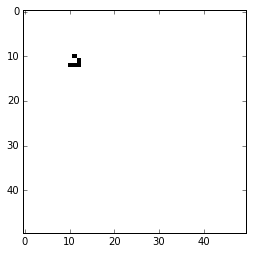

In [47]:
model = Life(50)
model.glide(10)
figure = plt.figure()
axes = plt.axes()
image = axes.imshow(model.current, cmap='Greys',  interpolation='nearest', animated = True)


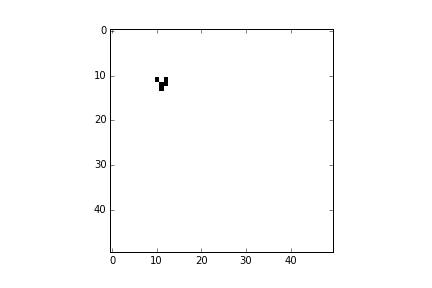
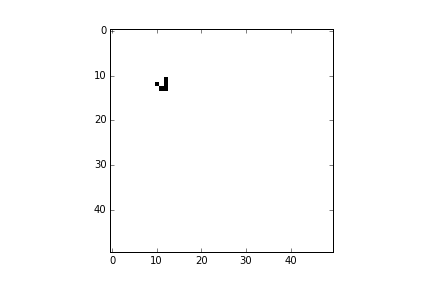
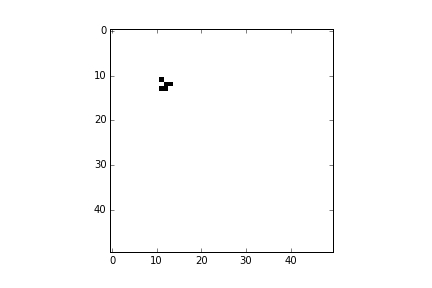
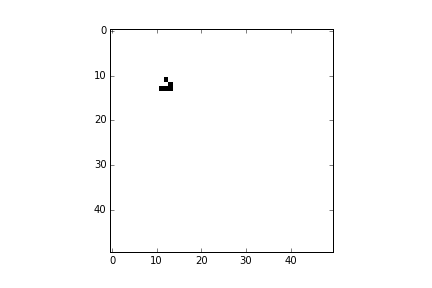
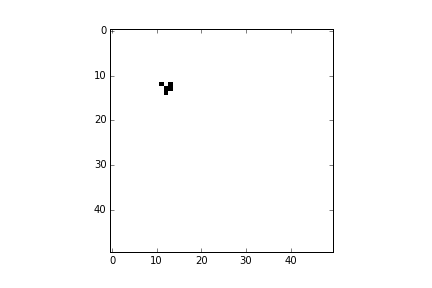
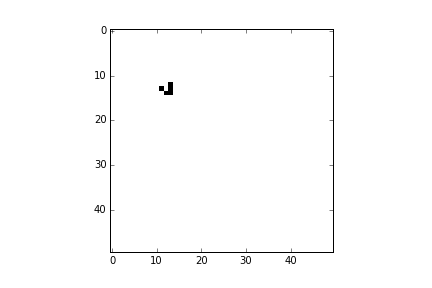
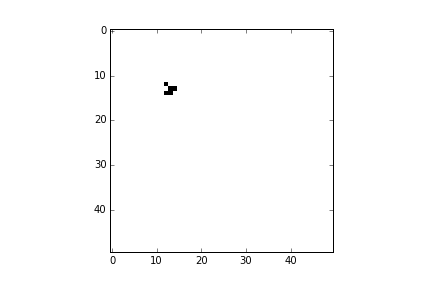
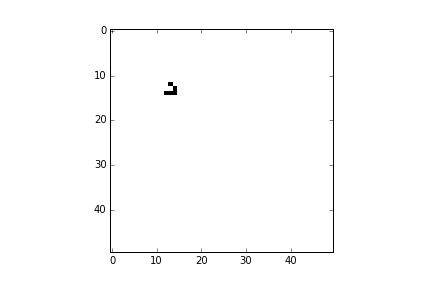
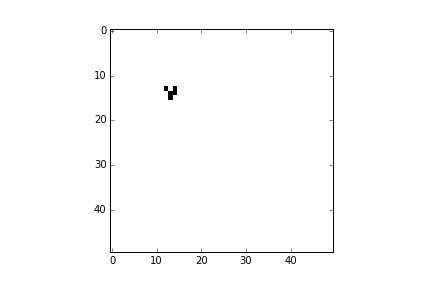
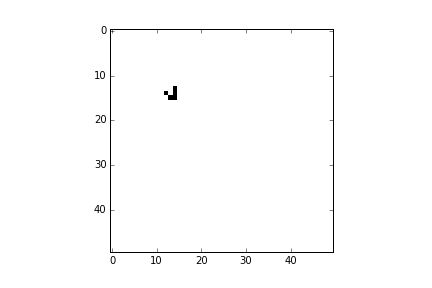
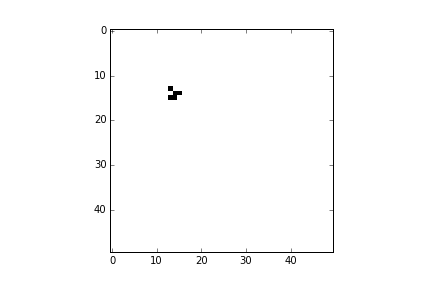
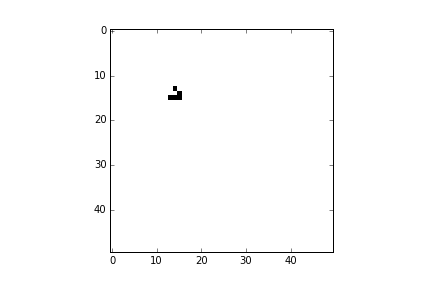
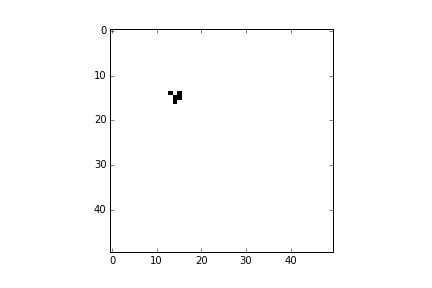
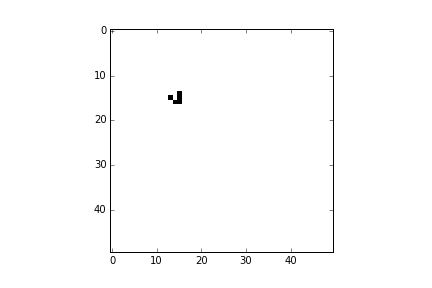
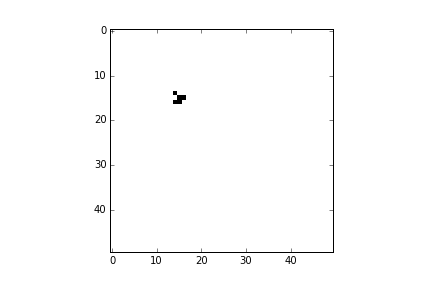
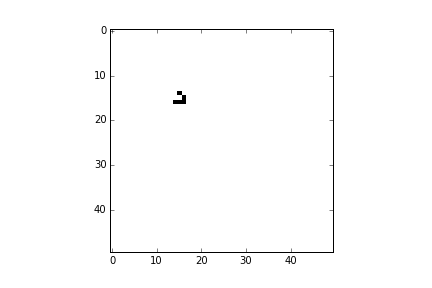
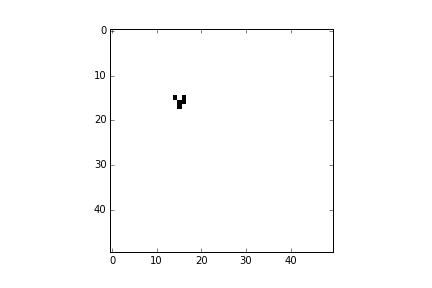
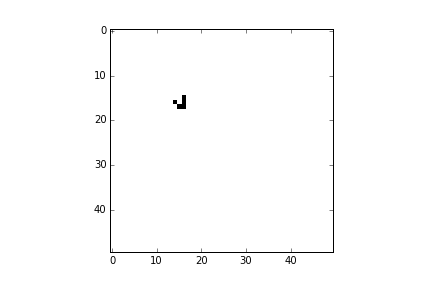
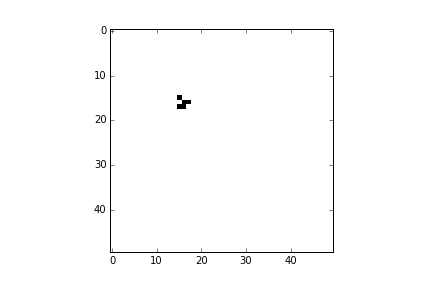
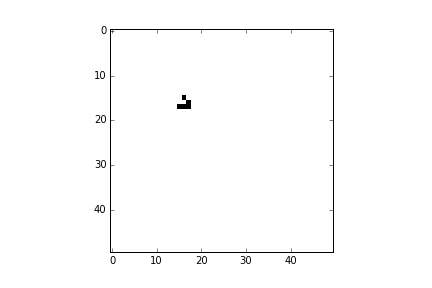
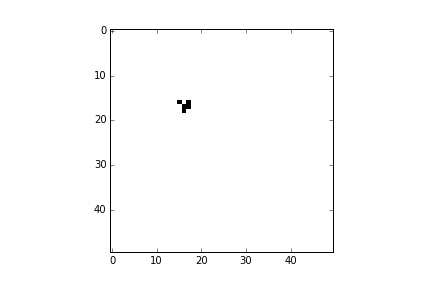
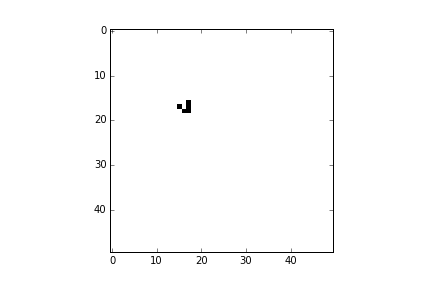
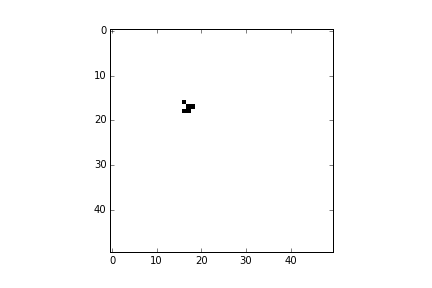
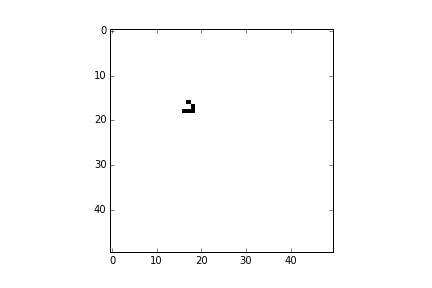
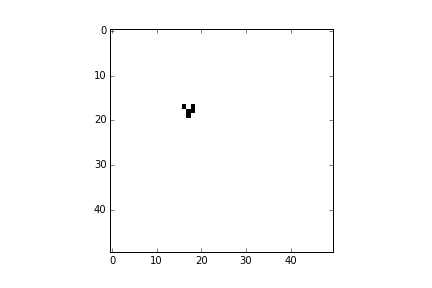
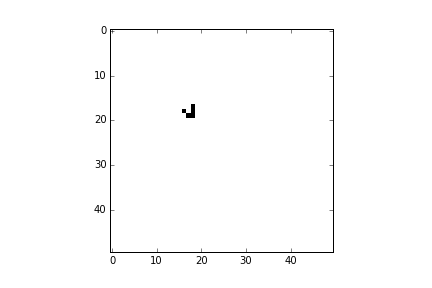
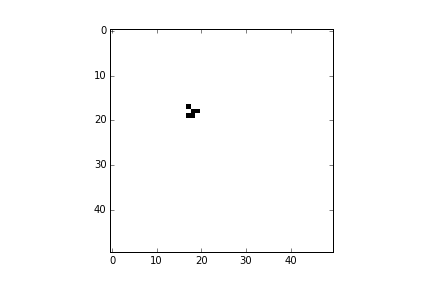
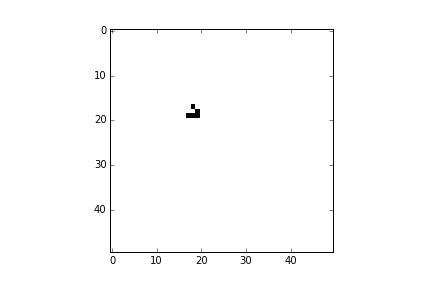
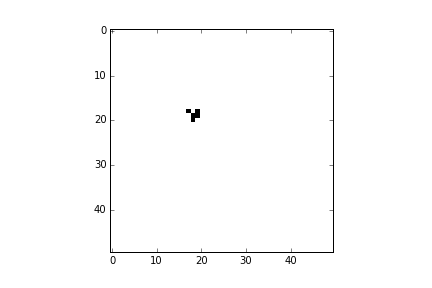
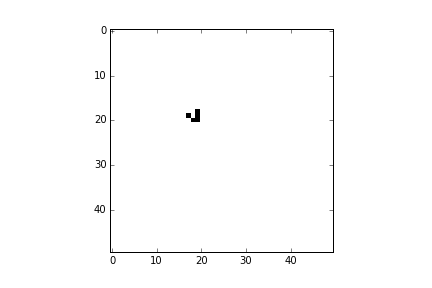
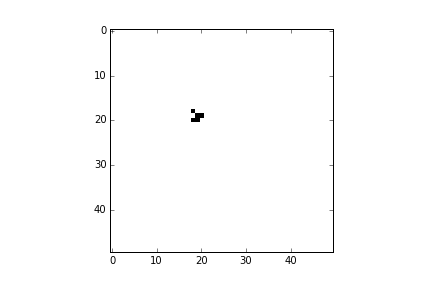
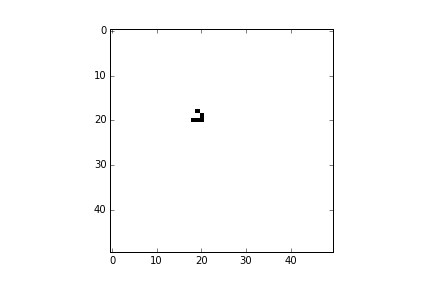
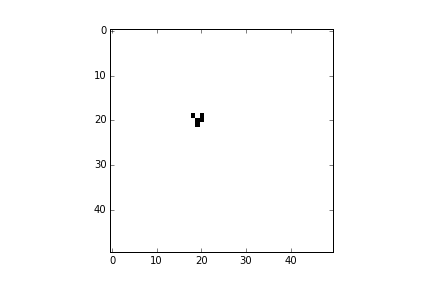
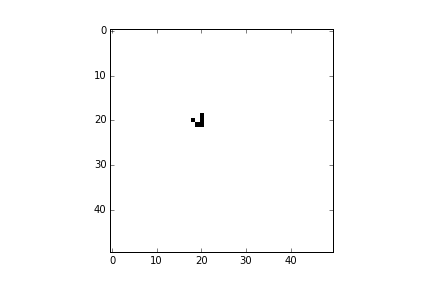
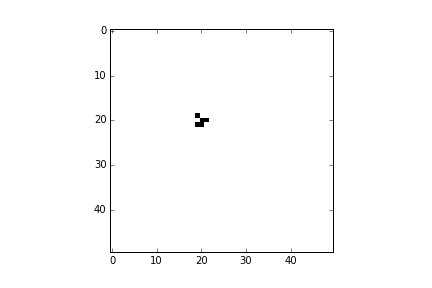
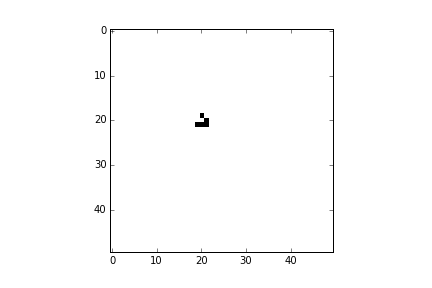
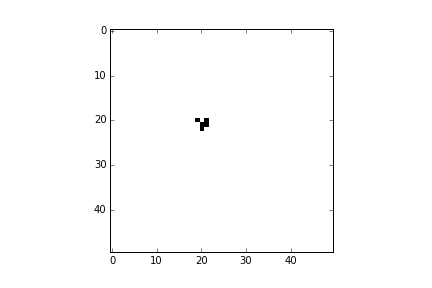
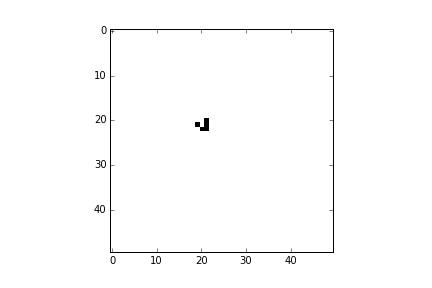
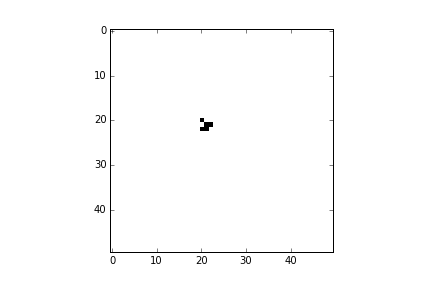
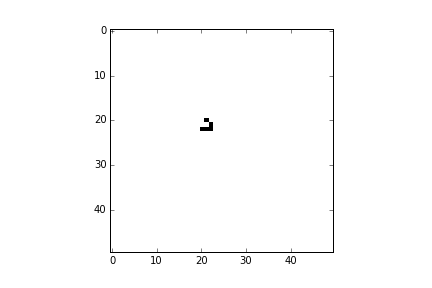
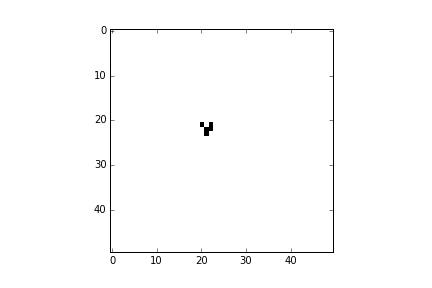
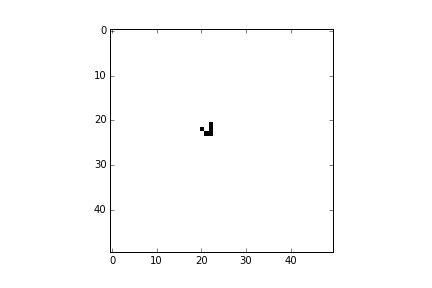
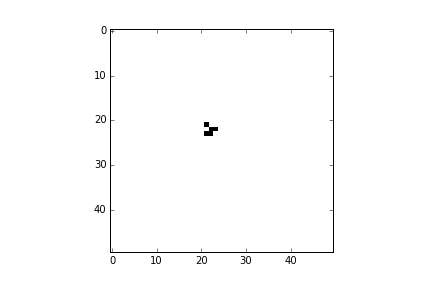
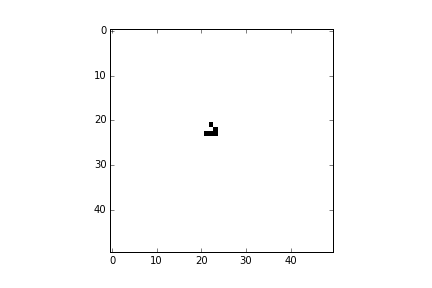
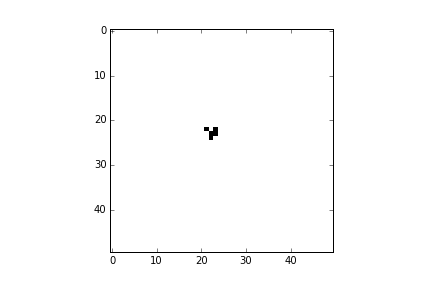
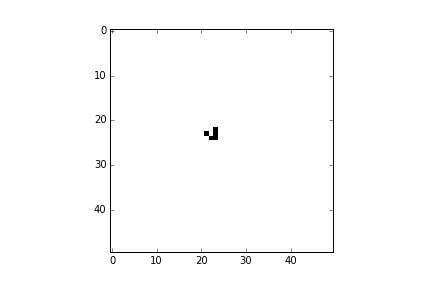
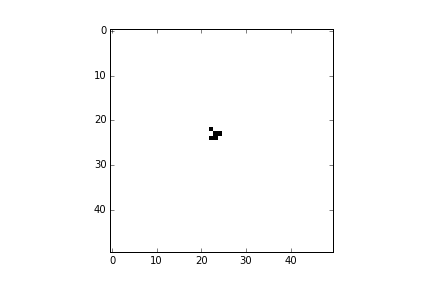
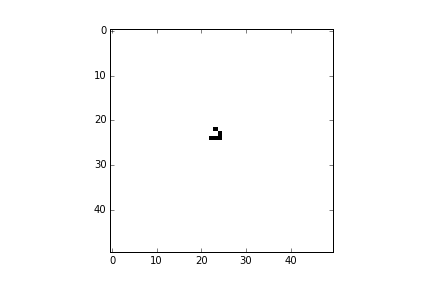
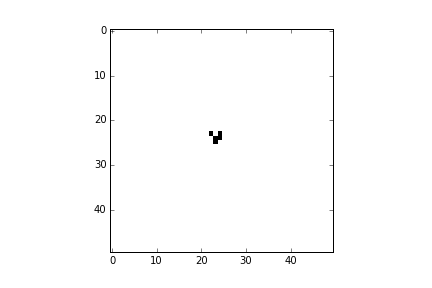
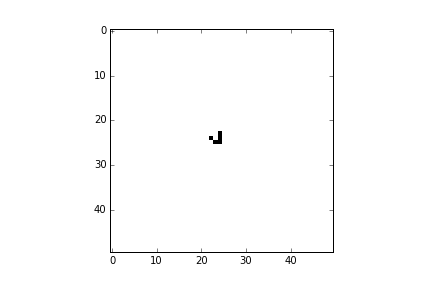
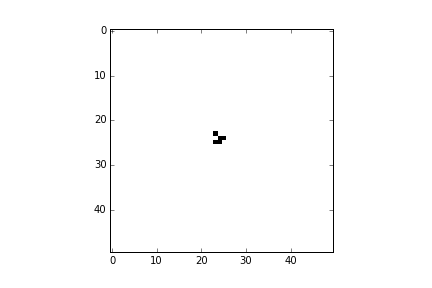
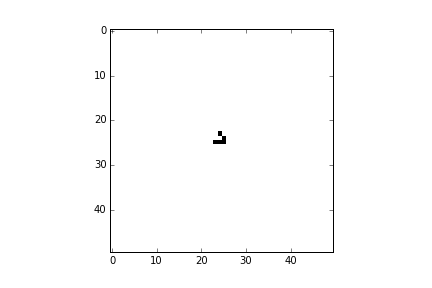
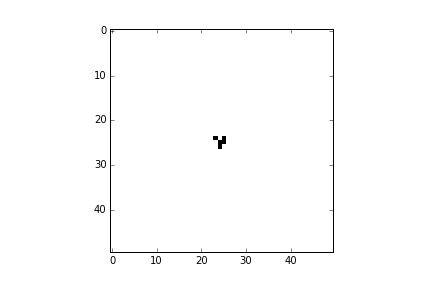
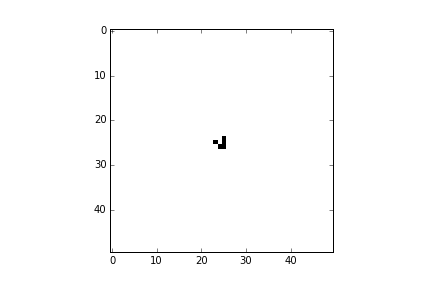
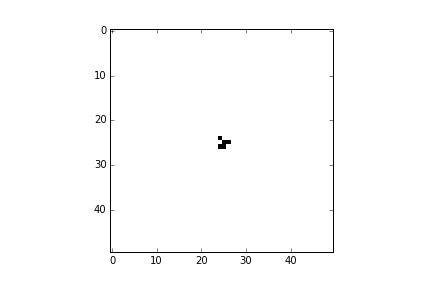
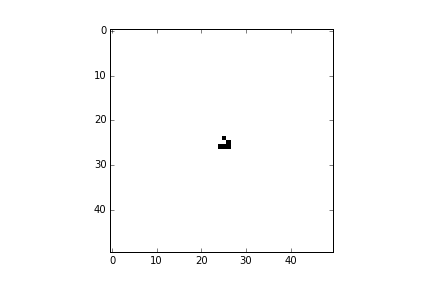
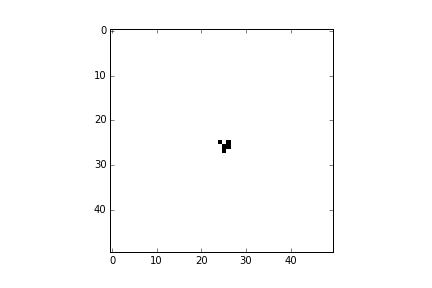
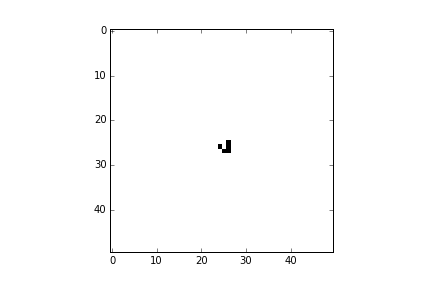
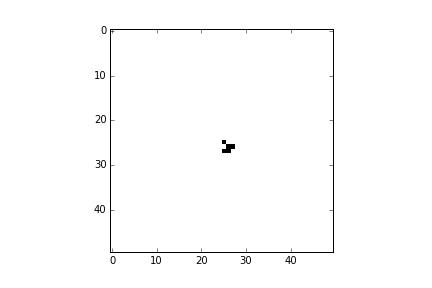
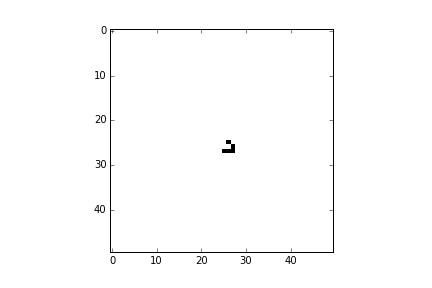
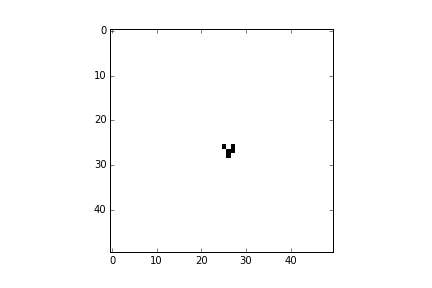
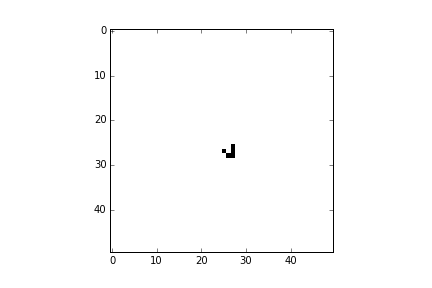
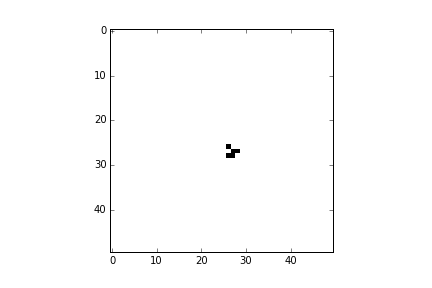
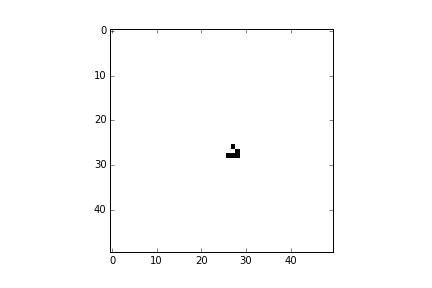
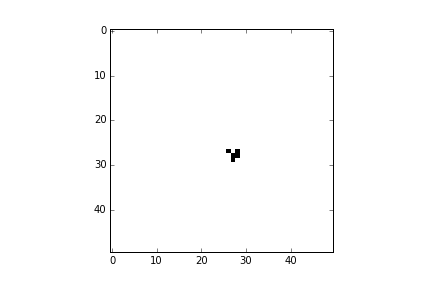
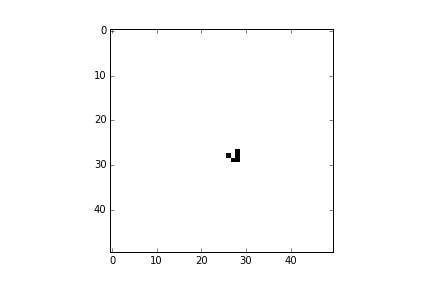
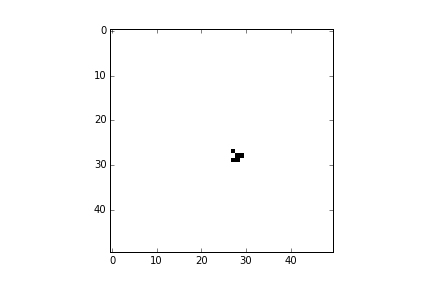
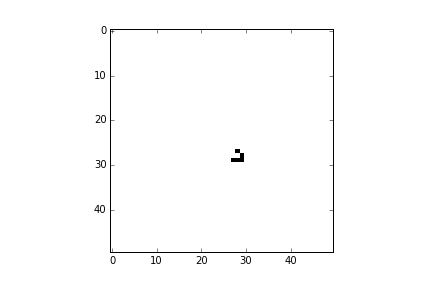
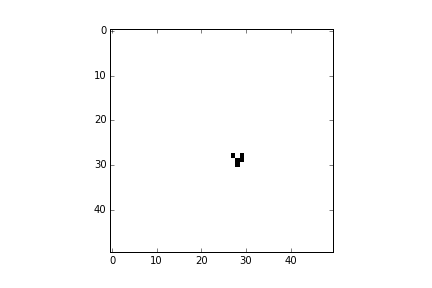
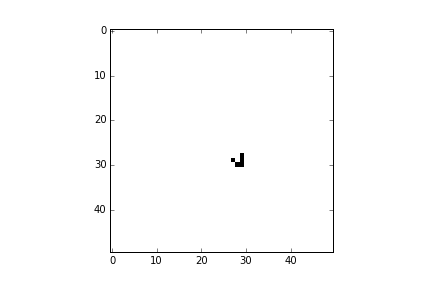
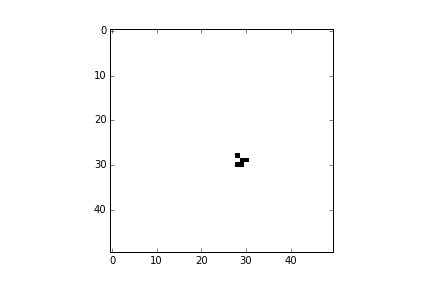
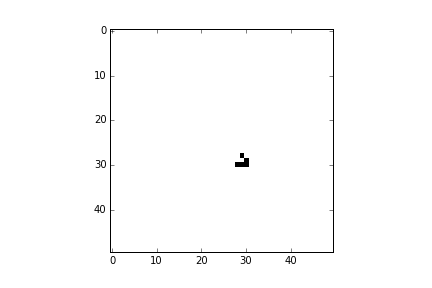
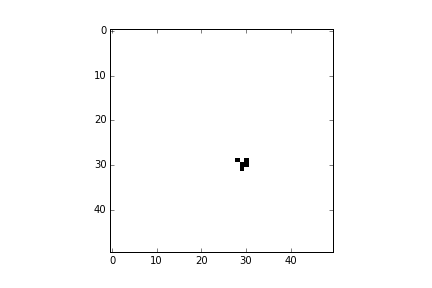
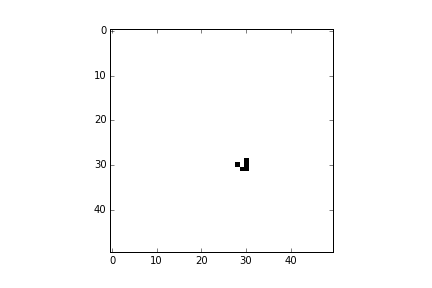
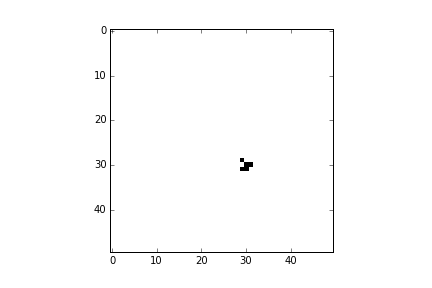
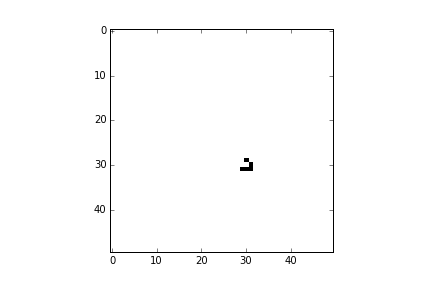
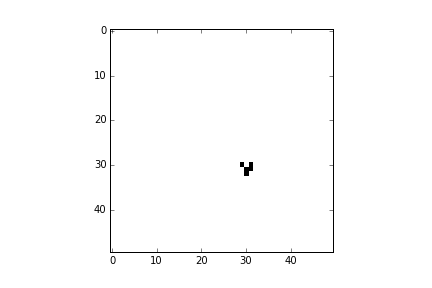
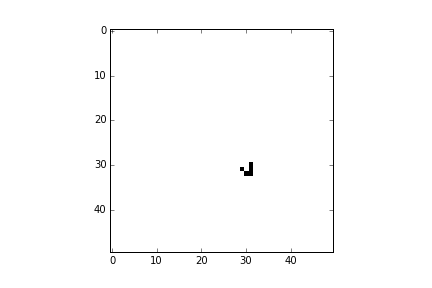
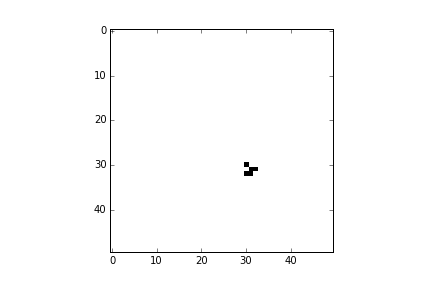
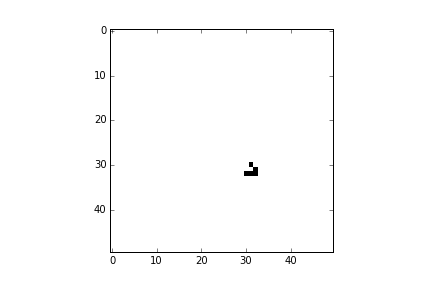
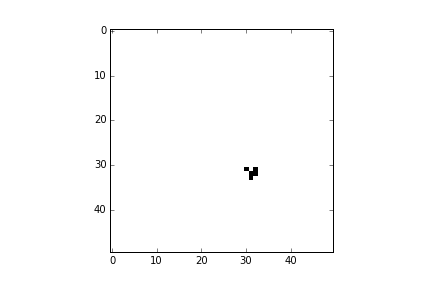
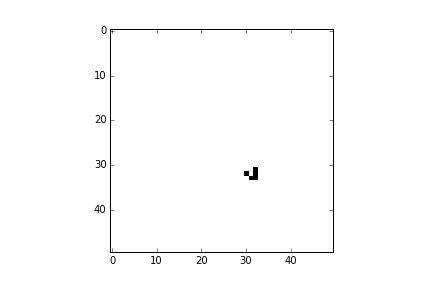
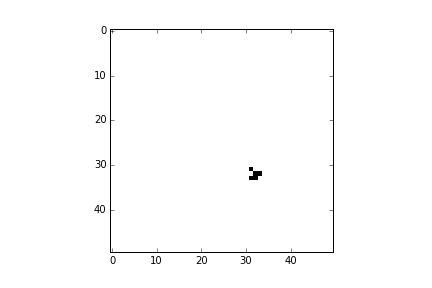
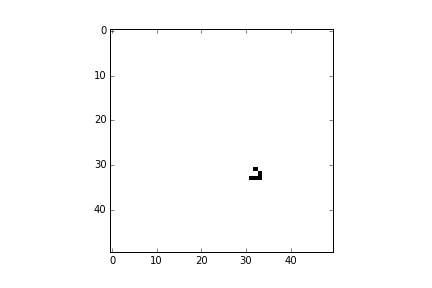
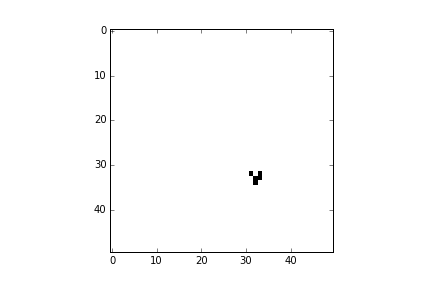
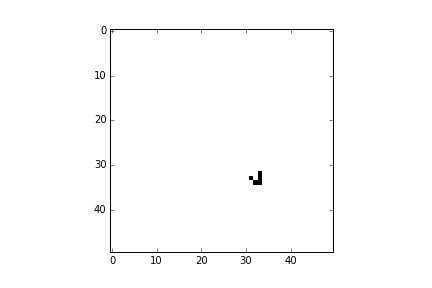
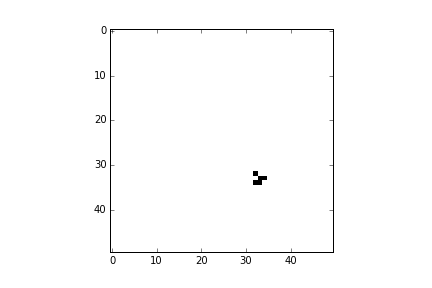
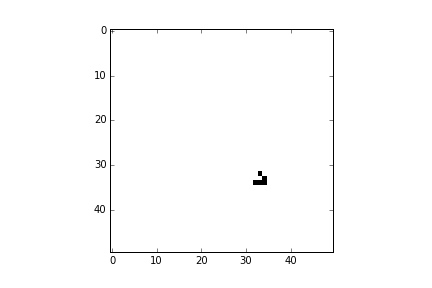
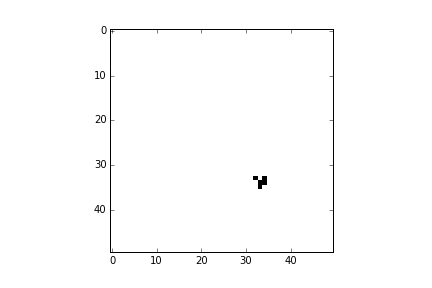
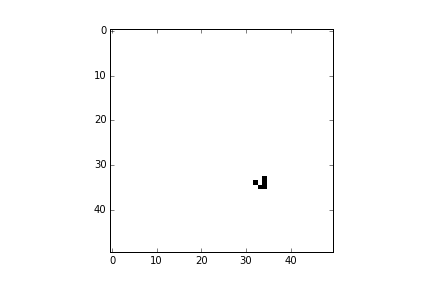
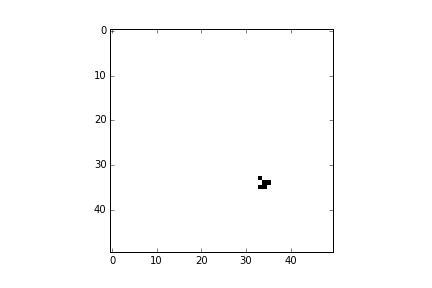
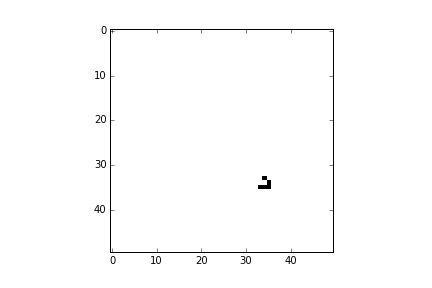
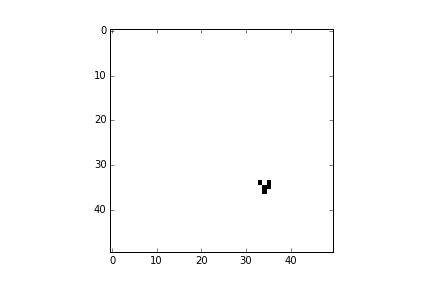
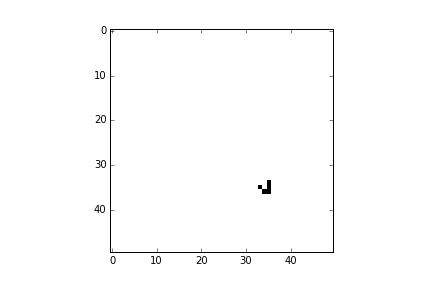
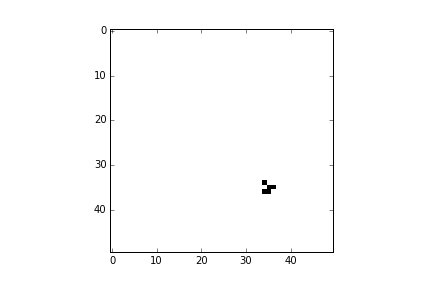
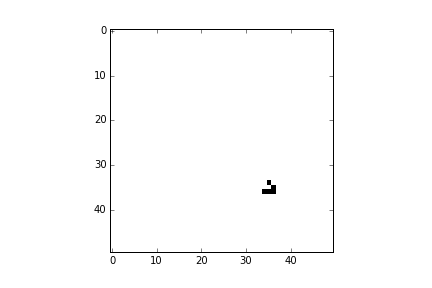
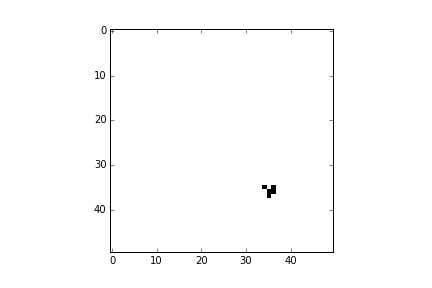
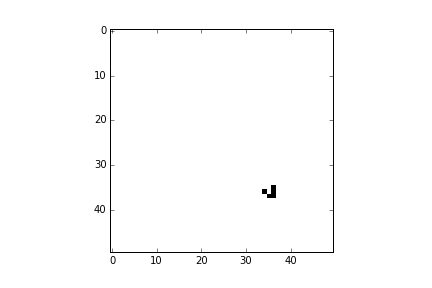
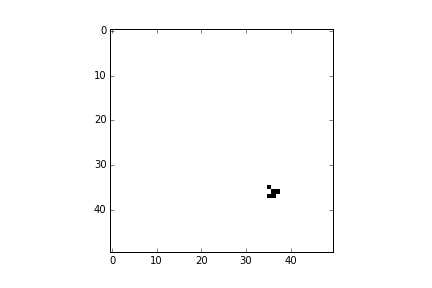
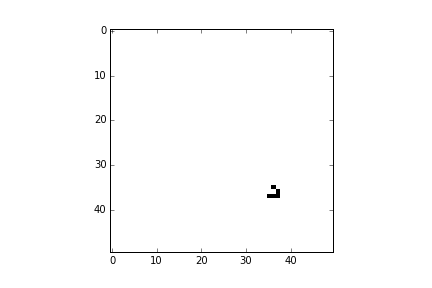
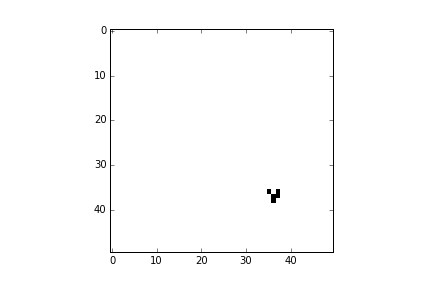
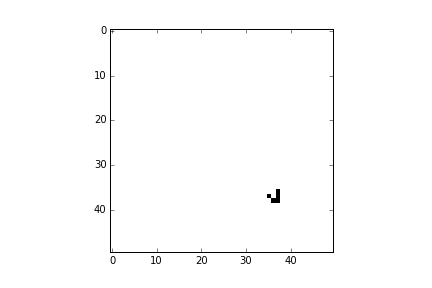
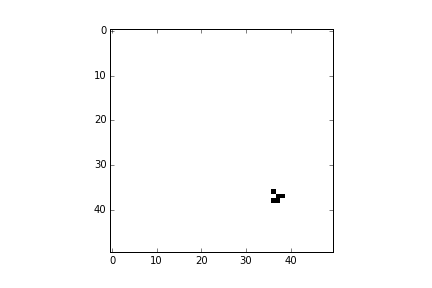
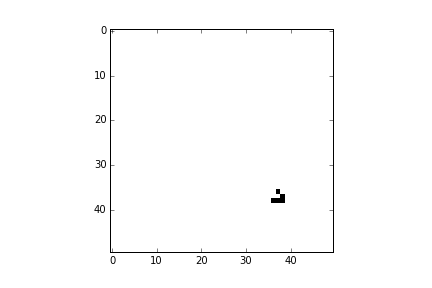
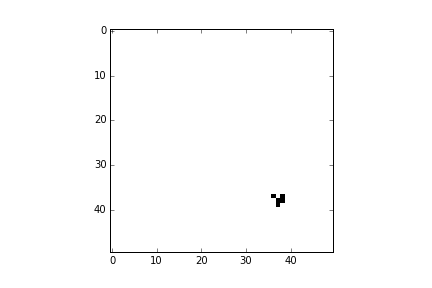
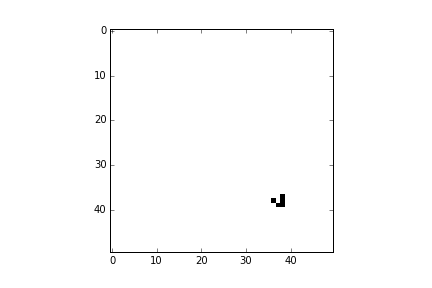
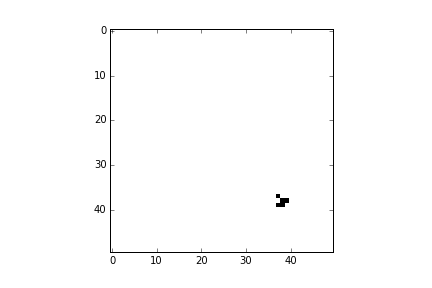
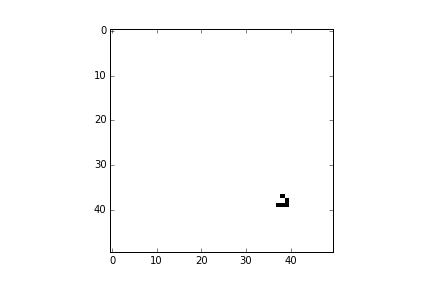
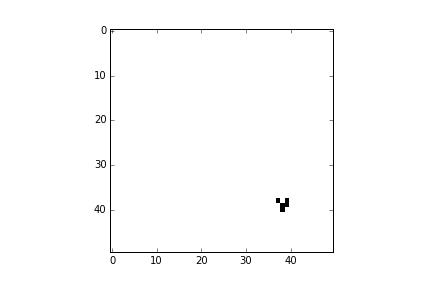
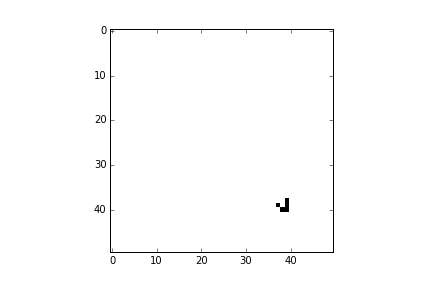
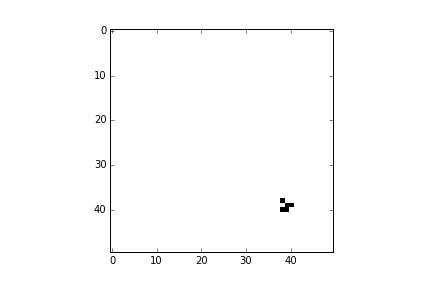
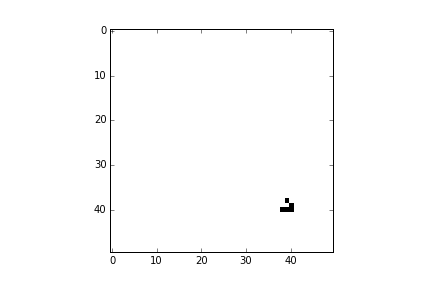
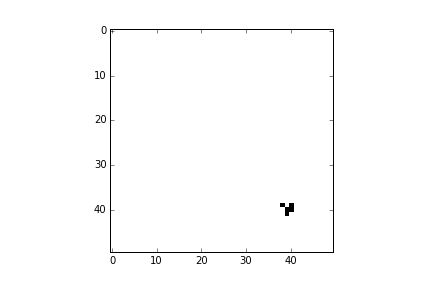
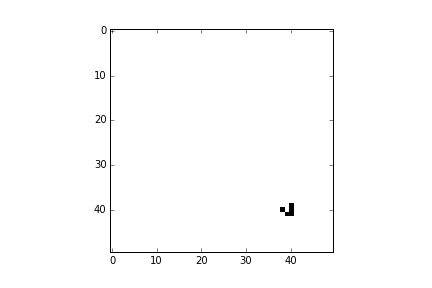
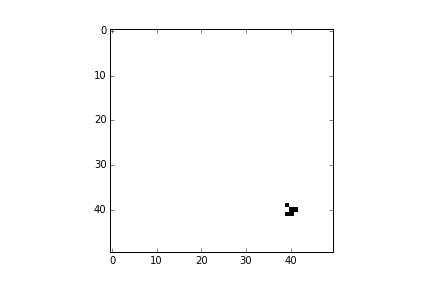
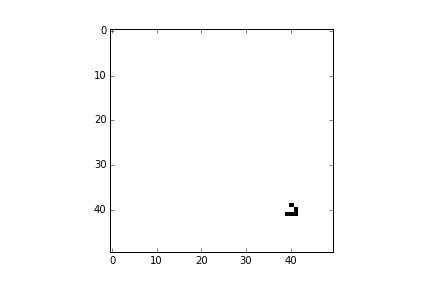
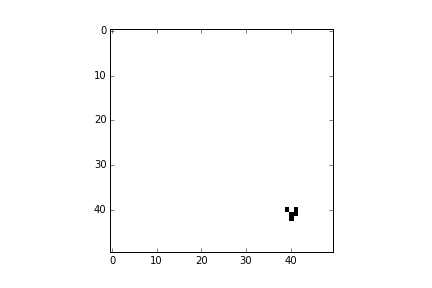
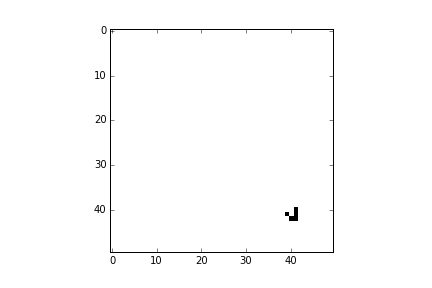
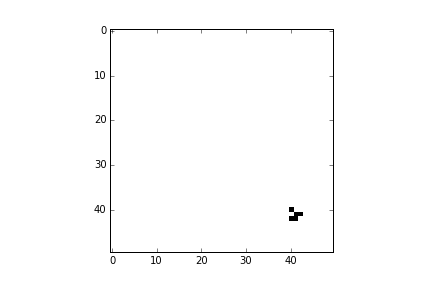
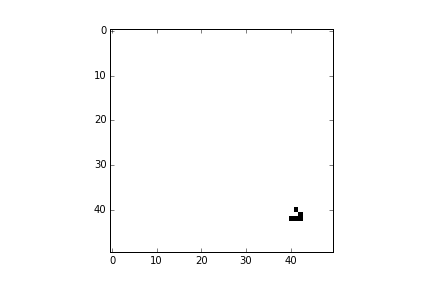
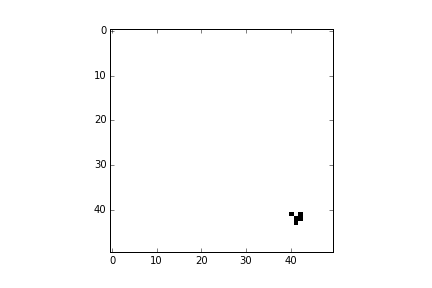
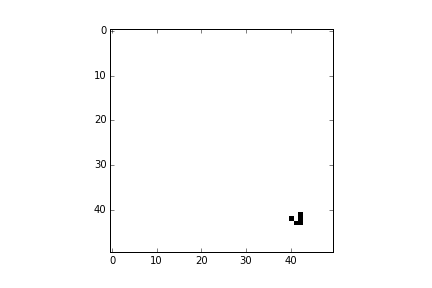
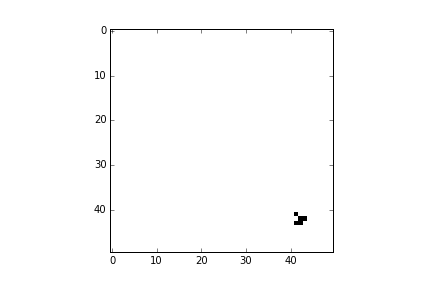
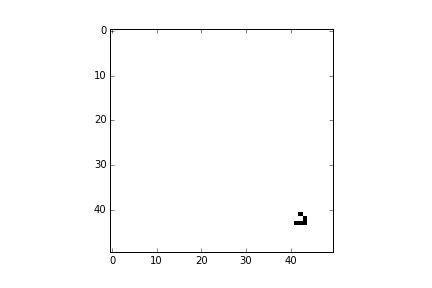
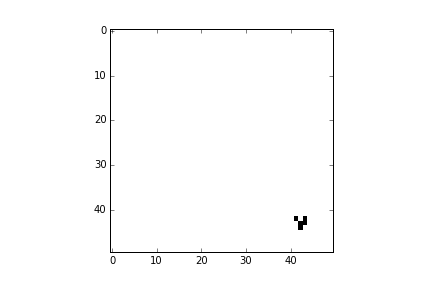
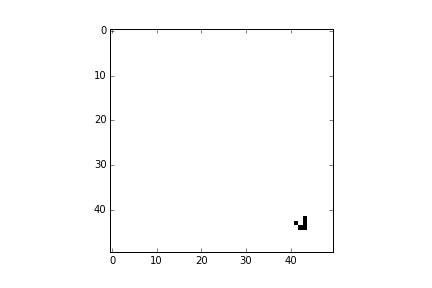
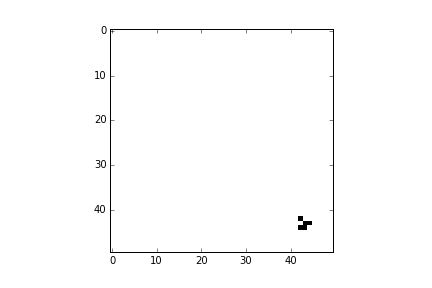
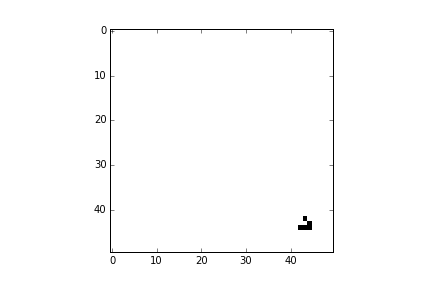
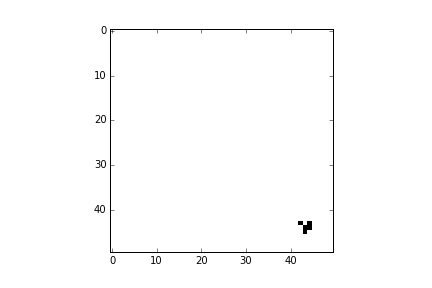
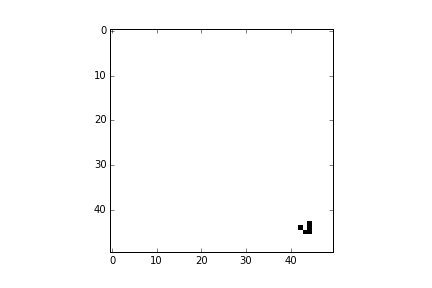
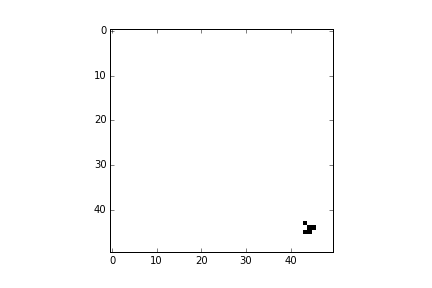
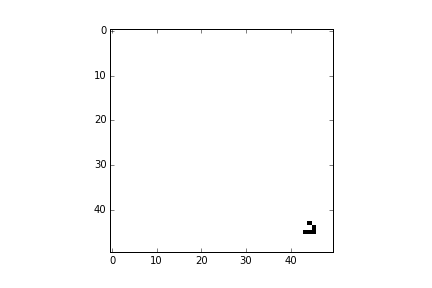
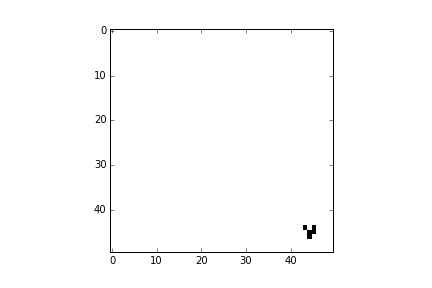
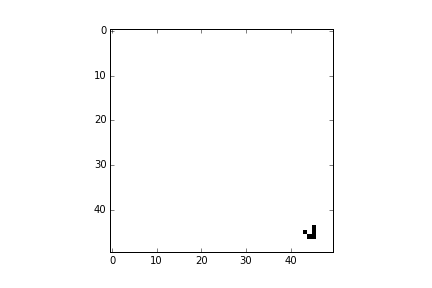
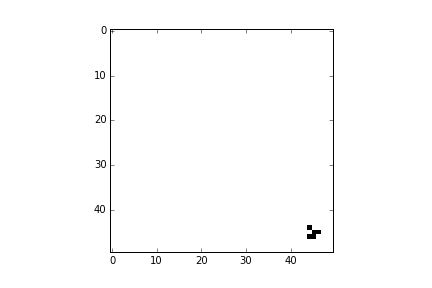
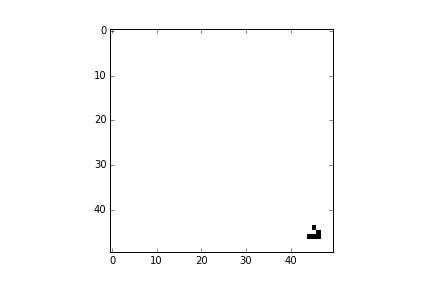
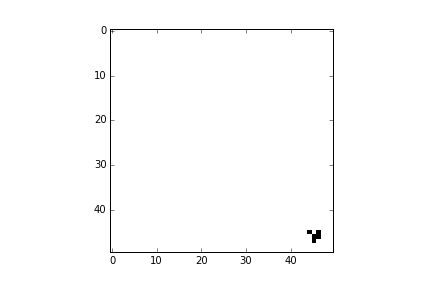
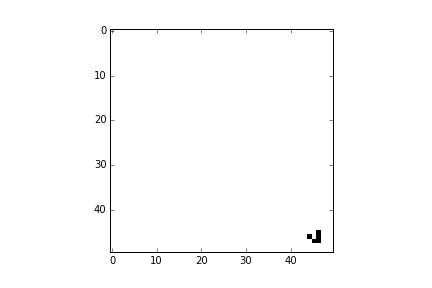
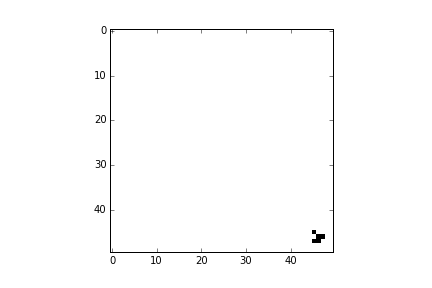
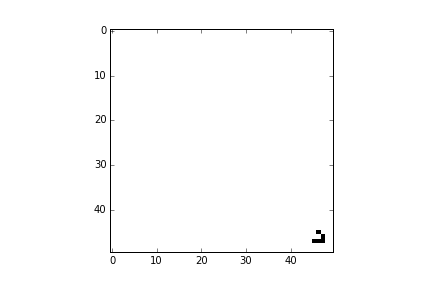
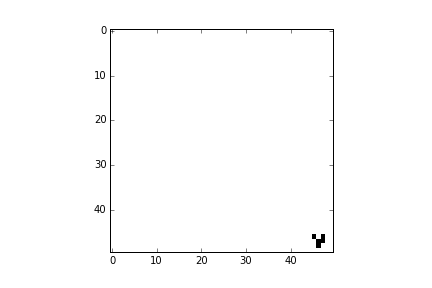
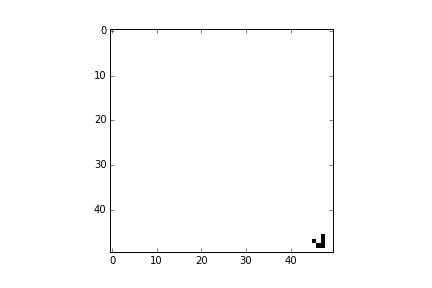
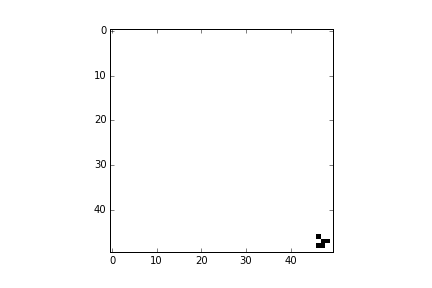
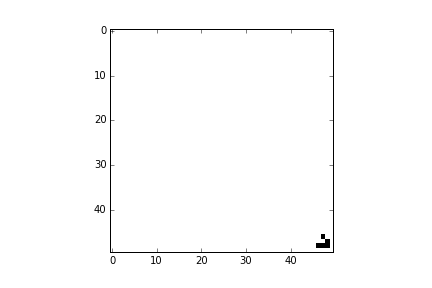
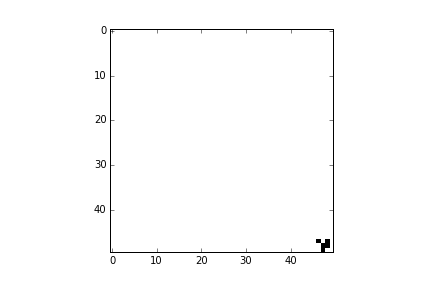
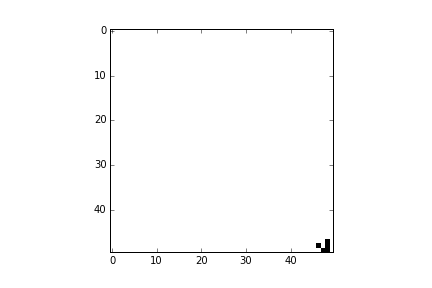
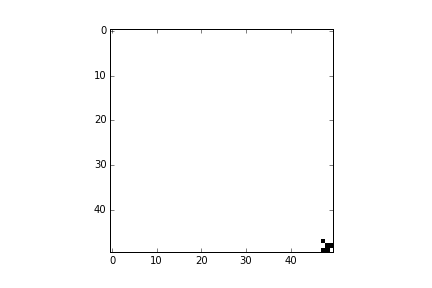
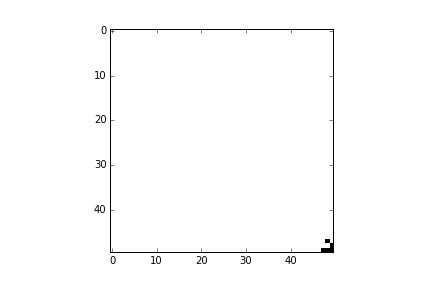
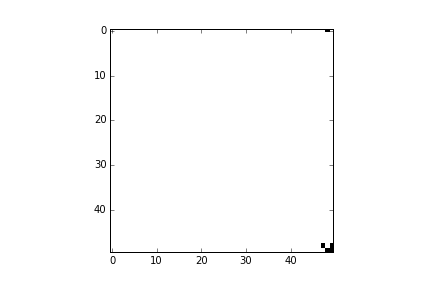
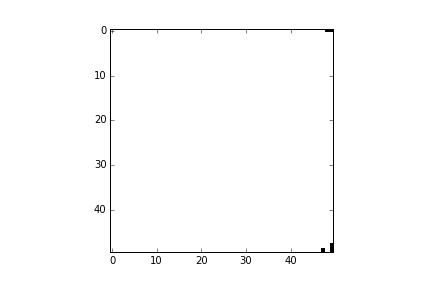
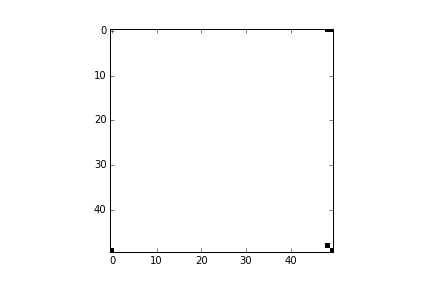
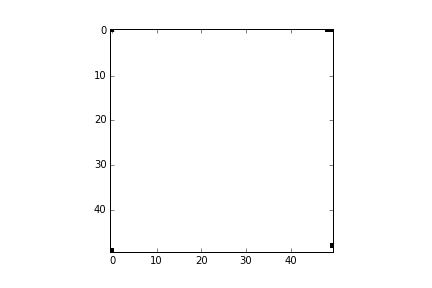
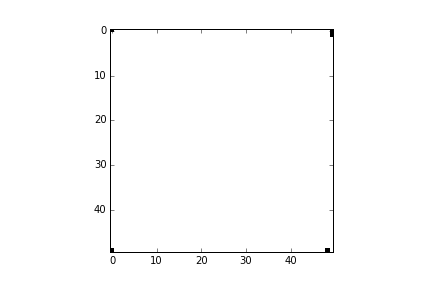
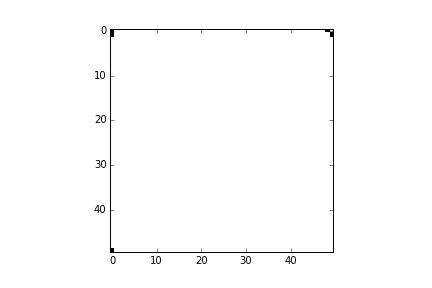
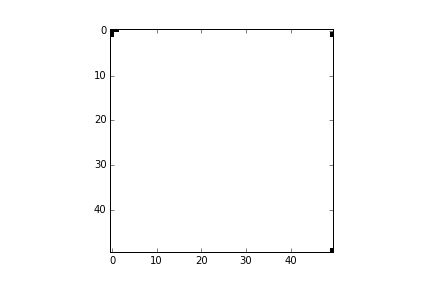
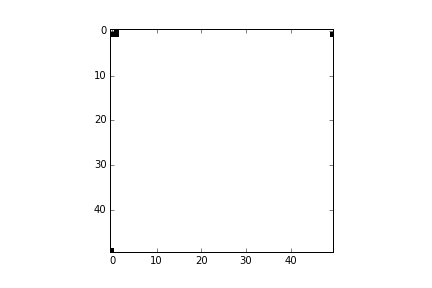
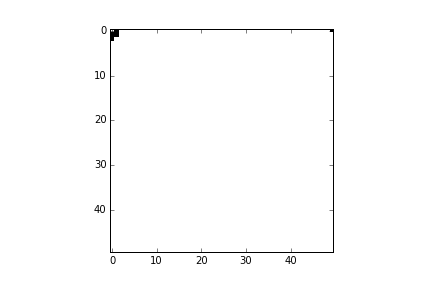
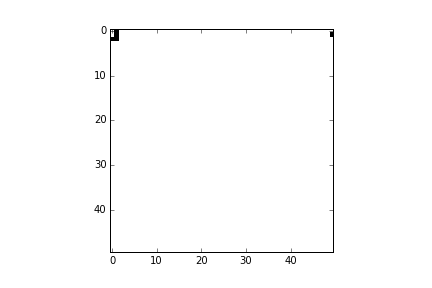
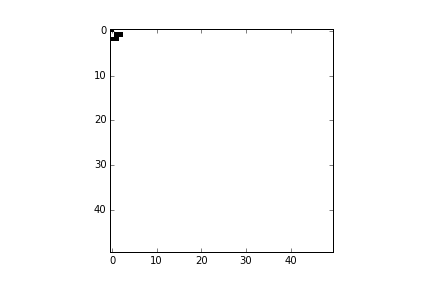
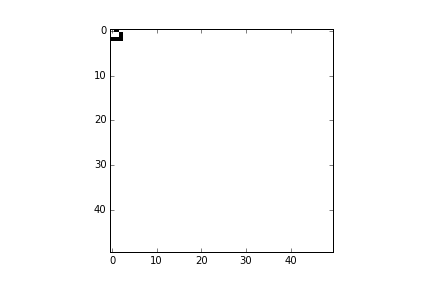
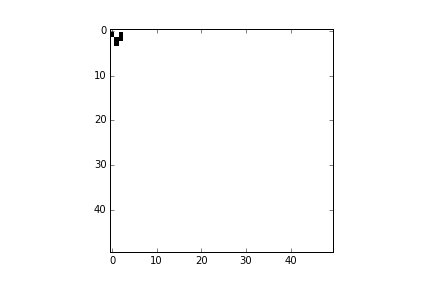
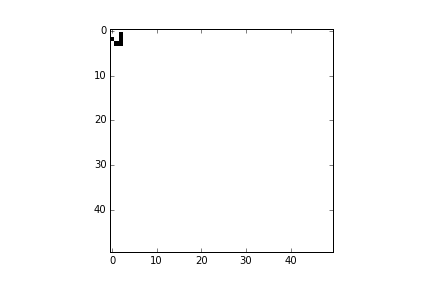
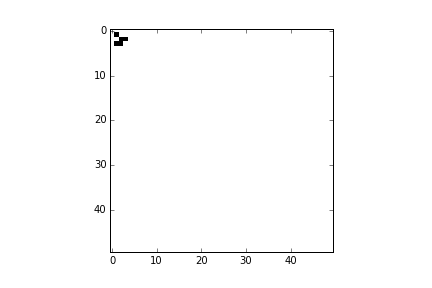
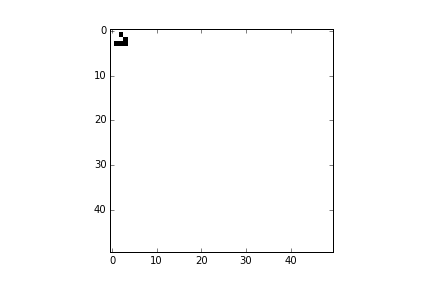
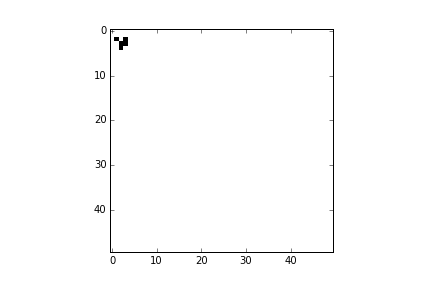
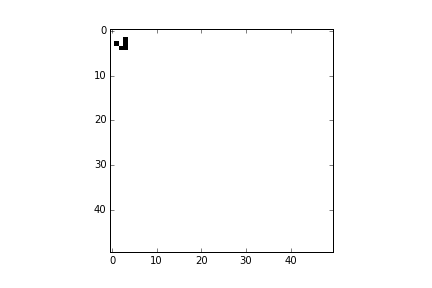
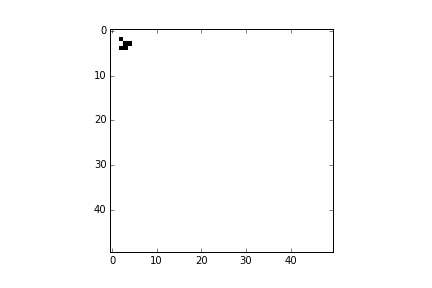
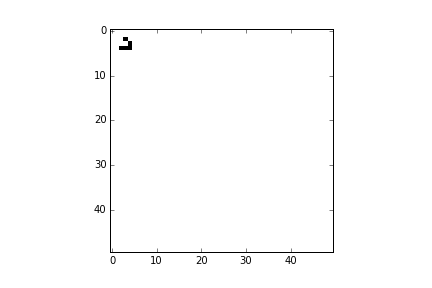
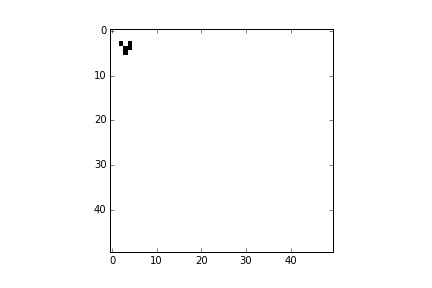
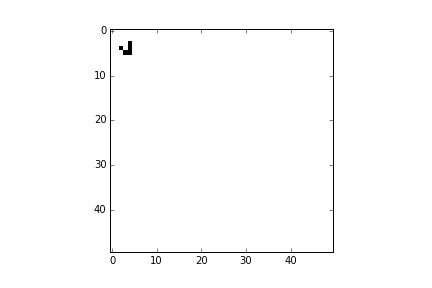
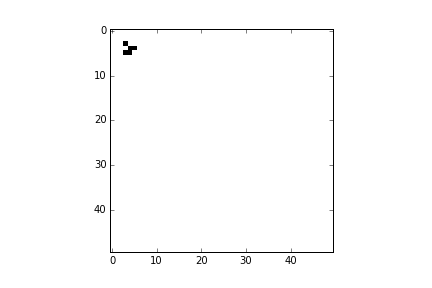
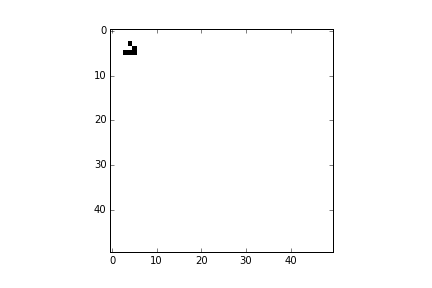
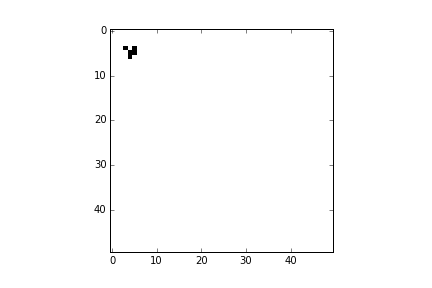
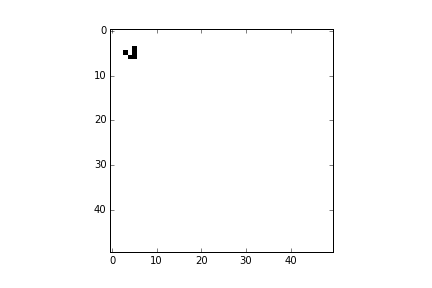
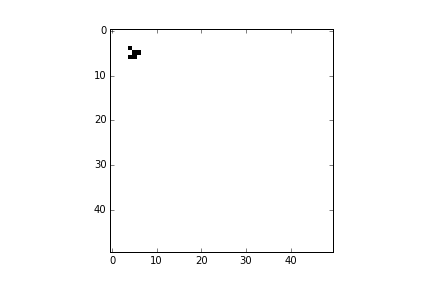
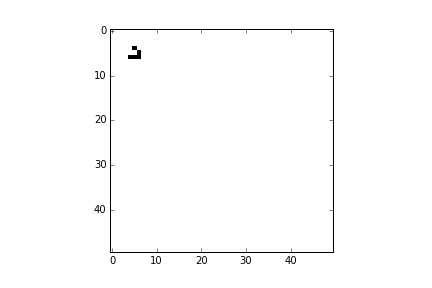
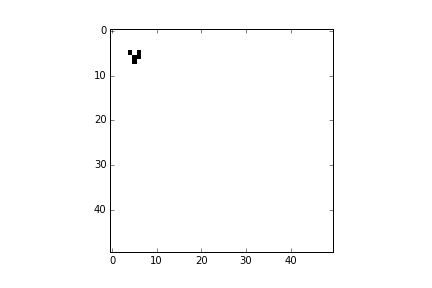
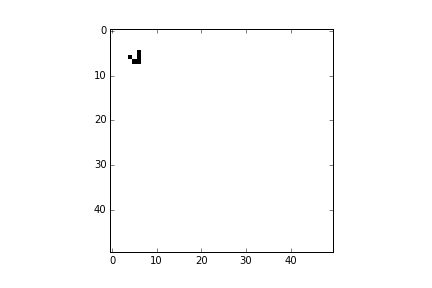
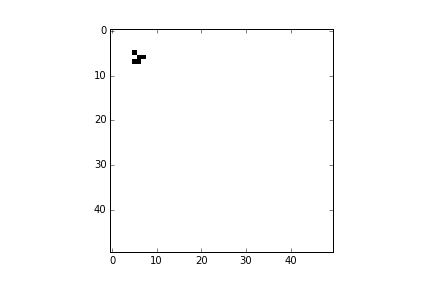
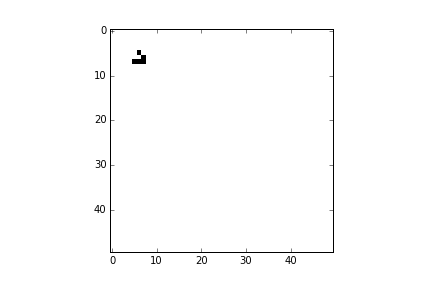
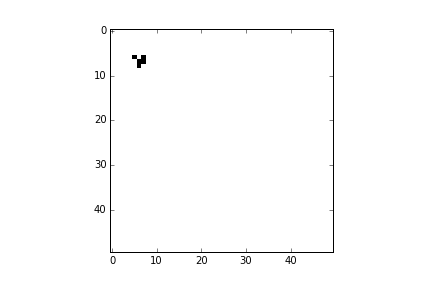
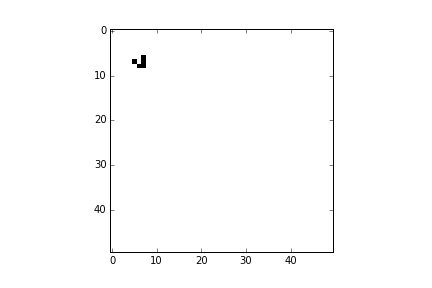
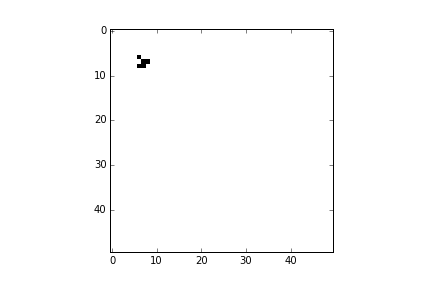
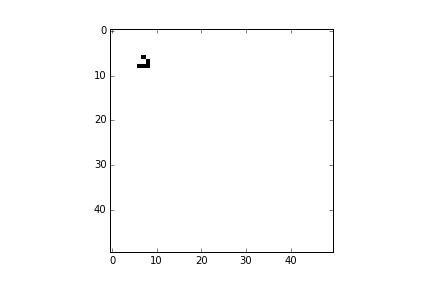
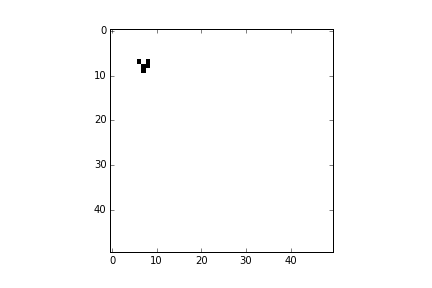
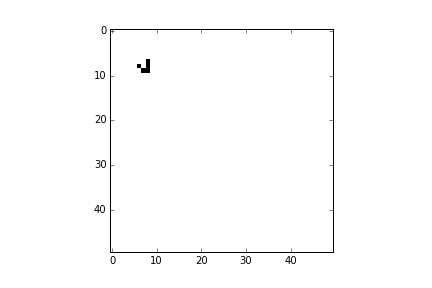
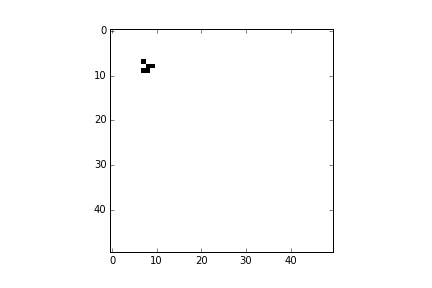
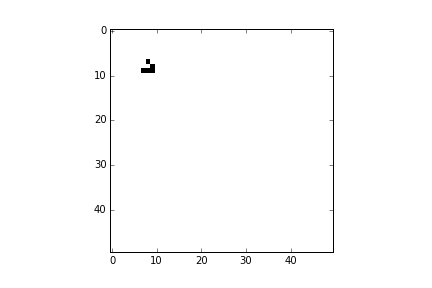
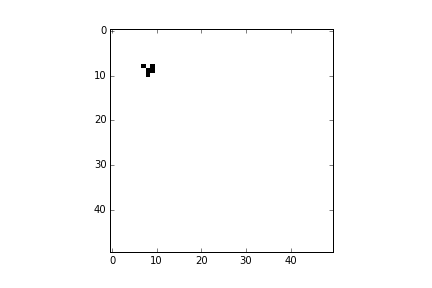
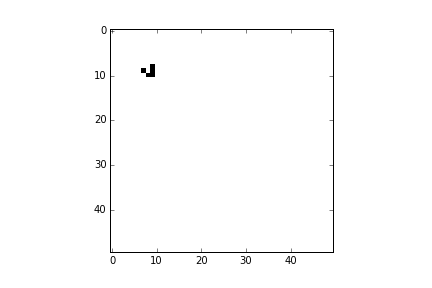
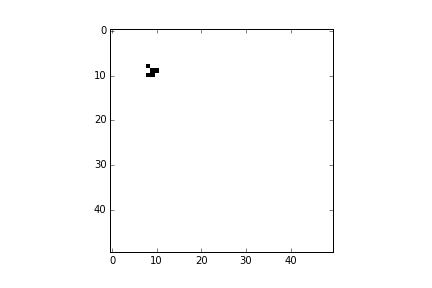
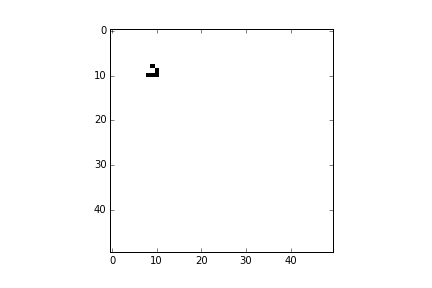
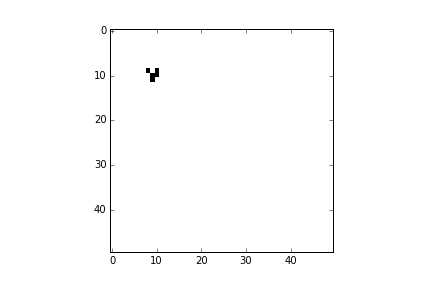
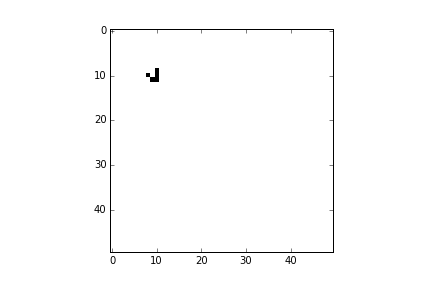
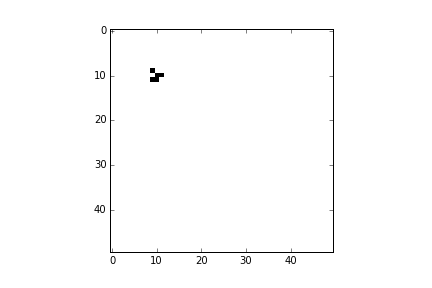
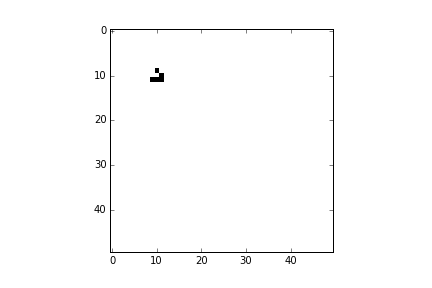
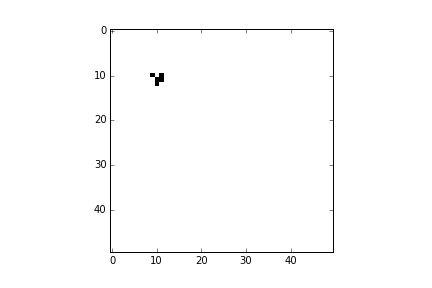
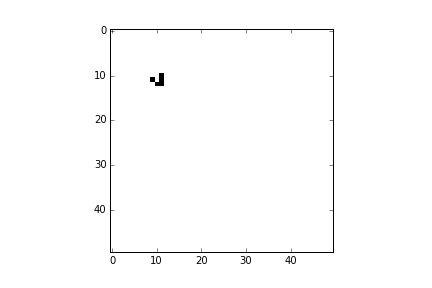
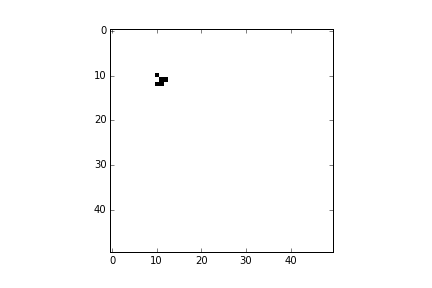
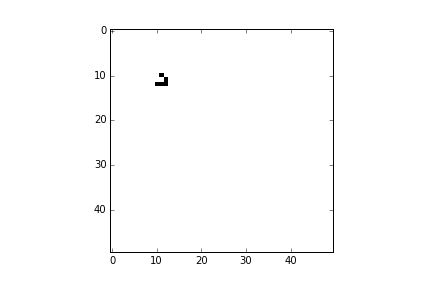

In [48]:
def animate(frame):
    image.set_array(model.current)
    model.step()

anim=animation.FuncAnimation(figure, animate,
                        frames=200, interval=20, blit=True)
from JSAnimation import IPython_display
anim  

The point of this is to build your visualisation infrastructure early, along with the code, as it
allows a much more fluent understanding of any problems than debugging through print statements or debuggers.

Tools such as Paraview and Visit are very helpful here.

## Testing Invariants and Conservation Laws


If it is too hard to manually build a fixture, we can test on a dervied property of the calculation which
we know. This could be a derivative of a function in the code with respect to one of its parameters, or a
conservation law for a simulation.

In [49]:
def yield_count_conway(limit):
    model = Life(50)
    model.glide(10)
    for _ in range(limit):
        yield np.sum(model.current)
        model.step()

In [50]:
list(yield_count_conway(5))

[5, 5, 5, 5, 5]

In [51]:
def test_conserved_conway():
    for total in yield_count_conway(200):
        assert total==5

test_conserved_conway()

## Testing Parallelism through Multiple Class Instances

When testing distributed memory parallelisation, we have found it helpful to write tests to validate separately the decomposition of the problem
and communication between processes, and the use of the parallel framework such as MPI.

Thus, a serial code which achieves, for example, a halo swap, between multiple instances of the class,
can be tested without parallelism to validate the bookkeeping

In [52]:
class OneDHaloLife(Life):
    def __init__(self, size):
        super(OneDHaloLife,self).__init__(size+2, size)
    
    def add_right_neighbour(self, neigh):
        self.right = neigh
        neigh.left = self
        
    def add_left_neighbour(self, neigh):
        self.left = neigh
        neigh.right = self
        
    def swap(self):
        self.current[-1,:] = self.right.current[1,:]
        self.current[0,:] = self.left.current[-2,:]

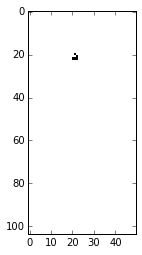

In [53]:
modelA = OneDHaloLife(50)
modelB = OneDHaloLife(50)
modelA.glide(20)

modelA.add_right_neighbour(modelB)
modelA.add_left_neighbour(modelB)

figure = plt.figure()
axes = plt.axes()
image = axes.imshow(np.vstack([modelA.current, modelB.current]), 
                    cmap='Greys',  interpolation='nearest', animated = True)

In [54]:
def animate(frame):
    image.set_array(np.vstack([modelA.current, modelB.current]))
    modelA.swap()
    modelB.swap()
    modelA.step()
    modelB.step()

In [ ]:
from matplotlib import animation
anim=animation.FuncAnimation(figure, animate,
                        frames=250, interval=20, blit=True)
from JSAnimation import IPython_display
anim

## Testing documentation

Documentation is universally accepted as a fundamental part of software
development \cite{Forward2002, Letherbridge2003}. However, documentation should
be thought of as a potential source for bugs as much as the source code itself.
It is very easy to change a feature in the course code, very and adjust the
testing framework but forget to update the documentation for a feature change.

Thus, it is important to incorporate a test of the documentation. Python has a
framework entitled `doctest` which will parse any file for `>>>` and `...` and
will run the associated code checking that the asserted output is obtained.
This is how documentation could be written for the `divisible_by_11` function written earlier:

```python
When running our function on the first 10 numbers divisible by 11 we get:

>>> for k in range(10):
...     print(divisible_by_11(11 * k))
True
True
True
True
True
True
True
True
True
```


To run the above (assuming it's saved in a `doc.rst` file) we use: `python -m
doctest cod.rst`. Doc tests can be incorporated with any of the previously
mentioned paradigms.

## Conclusions